In [20]:
import tensorflow as tf # version 2.18
from tensorflow.python import keras
from keras import layers, callbacks, models # from tensorflow.keras
from keras import preprocessing
from keras import optimizers
# from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [21]:
# define path
train_dir = "./data/cnn_train_data"
test_dir = "./data/cnn_test_data"
valid_dir = "./data/cnn_valid_data"

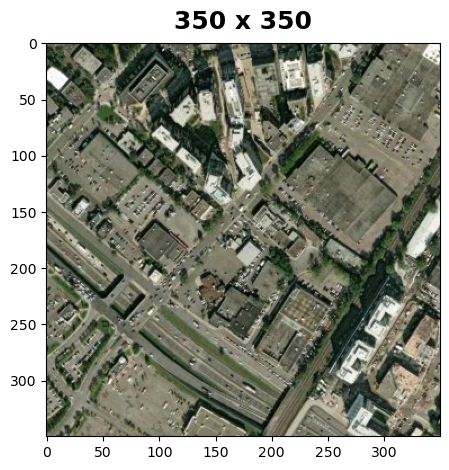

In [22]:
# debug
# display a single image

wildfire_dirname = 'nowildfire'

# ./data/cnn_train_data/wildfire/{image name}.jpg

def display_single_image (dir):
    wildfire_dir = os.path.join(dir, wildfire_dirname)
    img_fn = np.random.choice(os.listdir(wildfire_dir))
    img_path = os.path.join(wildfire_dir, img_fn)
    img = preprocessing.image.load_img(img_path)

    plt.imshow(img)
    plt.title(f"{img.size[0]} x {img.size[1]}")

    plt.show()

display_single_image(train_dir) # find image size for image_size parameter for preprocessing.image_dataset_from_directory

In [23]:
# THIS CODE BLOCK REMOVES IMAGES FROM OUR TRAINING/VALIDATION DATA DIRECTORIES IN THE CASE THAT THEY CAN'T BE DECODED (ONLY NEEDS TO BE RAN ONCE)
# We downloaded the training data as zip files, unzipped them locally by going into file explorer, selecting the files, and clicking "extract all" 

from struct import unpack
from tqdm import tqdm
import os
    
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}
    
class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        
    
bads = []
root_img_train_wildfire = "./data/cnn_train_data/wildfire"
root_img_train_nowildfire = "./data/cnn_train_data/nowildfire"
root_img_valid_wildfire = "./data/cnn_valid_data/wildfire"
root_img_valid_nowildfire = "./data/cnn_valid_data/nowildfire"
root_img_test_wildfire = "./data/cnn_test_data/wildfire"
root_img_test_nowildfire = "./data/cnn_test_data/nowildfire"

for root_img in [root_img_train_wildfire, root_img_train_nowildfire, root_img_valid_wildfire, root_img_valid_wildfire, root_img_test_wildfire, root_img_test_nowildfire]:
  for img in tqdm(os.listdir(root_img)):
    image = os.path.join(root_img, img)
    image = JPEG(image) 
    try:
      image.decode()   
    except:
      bads.append(img)

  for name in bads:
    os.remove(os.path.join(root_img, name))
  bads = []

# print(bads)

100%|██████████| 2820/2820 [00:03<00:00, 827.73it/s]


In [24]:

# Load training and validation sets (THIS IS SET TO BINARY RIGHT NOW, BUT WE WANT TO RETURN A NUMERICAL VALUE BETWEEN 0 AND 1 TO REPRESENT RISK)
# WE WILL KEEP IT BINARY FOR NOW JUST TO TEST THE MODEL'S ACCURACY SINCE THE TRAINING DATA IS BINARY
# EVEN THOUGH THE IMAGES ARE 350 by 350 WE CAN JUST MANUALLY CHANGE THE image_size=[width, height] ACCORDINGLY (smaller images = faster training time)
ds_train_ = preprocessing.image_dataset_from_directory(train_dir, labels='inferred', label_mode='binary', image_size=[128, 128], interpolation='nearest', batch_size=32, shuffle=True)
ds_valid_ = preprocessing.image_dataset_from_directory(valid_dir, labels='inferred', label_mode='binary', image_size=[128, 128], interpolation='nearest', batch_size=32, shuffle=False)

Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


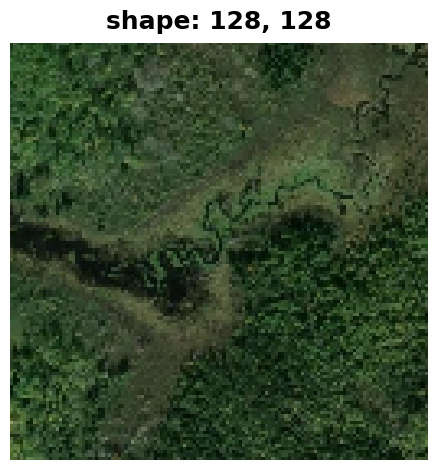

In [25]:
# Get a batch from the dataset (SEE WHAT THE UPDATED LOWER QUALITY IMAGE LOOKS LIKE)
image_batch, label_batch = next(iter(ds_train_))

# Get the first image in the batch
image = image_batch[0]

# Convert the image tensor to a numpy array for display
image = image.numpy().astype("uint8")

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis labels
plt.title(f'shape: {image.shape[0]}, {image.shape[1]}')
plt.show()


In [26]:
# Data Pipeline (convert images into a format the model can use)
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (ds_train_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
ds_valid = (ds_valid_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

In [27]:
#keep in mind there are other preprocessing data augmentation techniques that can be used
model = models.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]), # 350, 350 references image_size, WHAT DOES 3 REPRESENT? KERNEL_SIZE
    # Data Augmentation (THIS CHANGES OUR TRAINING DATA BY CHANGING THE CONTRAST OF THE IMAGES, FLIPPING THEM, AND ROTATING THEM RANDOMLY. THIS CAN BE HELPFUL FOR BINARY CLASSIFICATION LIKE IDENTIFYING CARS/TRUCKS, BUT NOT FOR CASES WHERE THE COLOR OR POSITION OF IMAGES ARE IMPORTANT)
    # layers.RandomFlip(mode='horizontal'), #preprocessing.RandomFlip()
    # layers.RandomRotation(factor=0.10),
    # Block One
    # layers.BatchNormalization(), # normalizes the data since a consistent distribution makes it easier for the model to find patterns
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'), # the model scans the image according to the kernel_size. 
    #Smaller values mean the model will pick up more distinct patterns, which could lead to overfitting (usually kernel_size is an odd number so there is a single kernel in the middle). 
    #This is a Conv2D layer which scans for a specific feature, which may not always be appropriate for every task. 
    #activation='relu' is used to detect features within the image, and is necessary to allow the model to pick up on non linear patterns 
    #(relevant pixels are labeled with 1, irrelevant pixels are labeled with 0). filters=64 determines how many changes are made to the original image to search for the right pattern.
    layers.MaxPool2D(), # MaxPool2D() removes pixels labeled with 0
    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    #layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'), # WHY ARE THERE 2 Conv2D LAYERS HERE (could lead to overfitting)
    layers.MaxPool2D(),
    # Head
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# optimizer adjusts the weights to minimize the loss, loss measures the disparity between true value and prediction
optimizer = optimizers.Adam(epsilon=0.01, weight_decay=0.0001) # the optimizer applies the activation to the line of best fit to find new patterns ('relu')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       524,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,913 (3.42 MB)

 Trainable params: 896,017 (3.42 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20


946/946 ━━━━━━━━━━━━━━━━━━━━ 581s 609ms/step - binary_accuracy: 0.8377 - loss: 0.4316 - val_binary_accuracy: 0.9368 - val_loss: 0.1890
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 538s 568ms/step - binary_accuracy: 0.8527 - loss: 0.3298 - val_binary_accuracy: 0.9079 - val_loss: 0.2228
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 548s 579ms/step - binary_accuracy: 0.8858 - loss: 0.2937 - val_binary_accuracy: 0.8095 - val_loss: 0.3166
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 531s 562ms/step - binary_accuracy: 0.8998 - loss: 0.2669 - val_binary_accuracy: 0.8481 - val_loss: 0.2728
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 533s 563ms/step - binary_accuracy: 0.9200 - loss: 0.2362 - val_binary_accuracy: 0.8232 - val_loss: 0.3463
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 531s 561ms/step - binary_accuracy: 0.9250 - loss: 0.2203 - val_binary_accuracy: 0.9179 - val_loss: 0.1698
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 531s 561ms/step - binary_accuracy: 0.9304 - loss: 0.2023 - val_binary_accuracy: 0.7957 - val_lo

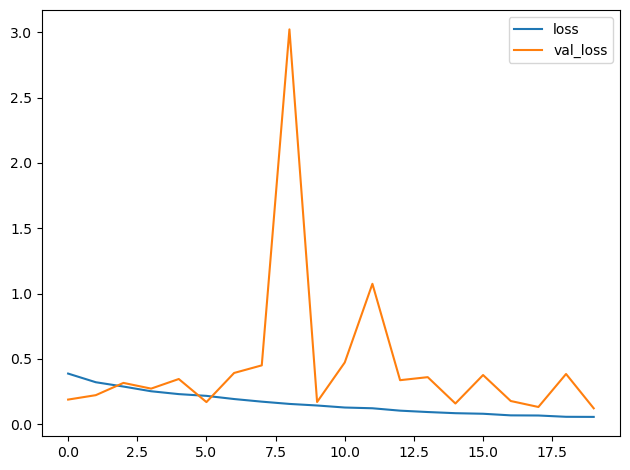

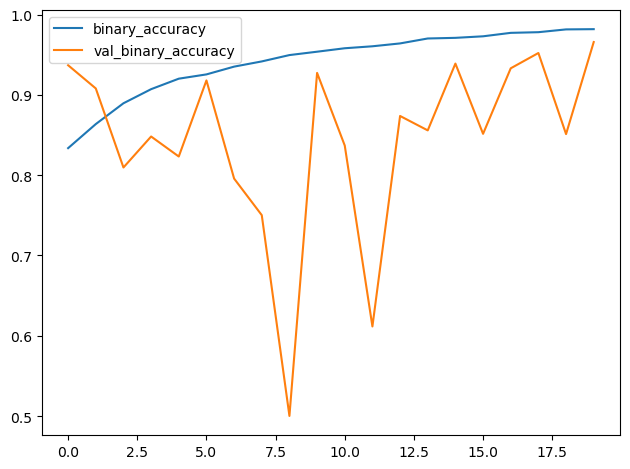

In [29]:
history = model.fit(ds_train, validation_data=ds_valid, epochs=20) # callbacks=[early_stopping] is omitted, so high epochs value may lead to overfitting

# Plot learning curves (val_binary_accuracy gets up to 90%)
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot() #title="" (loss line represents model accuracy on training data, val_loss represents model accuracy on the validation data aka the data that the model is not trained on. lower=better)
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(); # same concept as loss line except higher values are better
model.save('CNN_WILDFIRE_MODEL.keras') # save model to repo

In [30]:
test_data = preprocessing.image_dataset_from_directory('./data/cnn_valid_data', labels='inferred', label_mode='binary', image_size=[128, 128], interpolation='nearest', batch_size=32, shuffle=True) # confirm cnn_valid_data results match
test_data = (test_data.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
result = model.evaluate(test_data)
print(result)

Found 6300 files belonging to 2 classes.
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 162ms/step - binary_accuracy: 0.9655 - loss: 0.1231
[0.12201692163944244, 0.9657142758369446]


In [31]:
the_model = models.load_model('CNN_WILDFIRE_MODEL.keras') # Example of how to import and use the saved model (comparing test data results with validation data results)
test_data = preprocessing.image_dataset_from_directory('./data/cnn_test_data', labels='inferred', label_mode='binary', image_size=[128, 128], interpolation='nearest', batch_size=32, shuffle=True) # change to cnn_valid_data
test_data = (test_data.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
result = the_model.evaluate(test_data)
print(result)

Found 6299 files belonging to 2 classes.
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - binary_accuracy: 0.9740 - loss: 0.0827
[0.08768296241760254, 0.9719002842903137]


In [ ]:
# DISCLAIMER: THE PATHS USED IN THIS NOTEBOOK WITHIN THE data FOLDER HAVE BEEN DELETED FOR STORAGE PURPOSES
# THE TRAINING DATA FOR THIS MODEL WAS OBTAINED FROM https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset